In [1]:
# CELL 0: Setup and Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✓ All imports successful


In [2]:
# CELL 1: Seed Setting Function
def set_seeds(seed=42):
    """
    Set all random seeds for reproducibility
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
print("✓ Seed function defined")

✓ Seed function defined


In [3]:
# CELL 2: Helper Functions

def create_room_groups(df):
    """
    Create room_group column to identify consecutive room visits.
    Each time room changes, we start a new group.
    """
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['room_group'] = (df['room'] != df['room'].shift()).cumsum()
    return df

def create_beacon_count_vectors(df):
    """
    For each window, create a 23-dim vector where each value is the 
    percentage of times that beacon appeared (ignore beacons 24, 25)
    """
    vectors = []
    
    for _, group in df.groupby('timestamp'):
        # Count how many times each beacon appears in this window
        beacon_counts = group['mac address'].value_counts()
        total_readings = len(group)
        
        # Create 23-dim vector (beacons 1-23)
        vector = [0.0] * 23
        for beacon_id, count in beacon_counts.items():
            if 1 <= beacon_id <= 23:  # Only beacons 1-23
                vector[beacon_id - 1] = count / total_readings
        
        vectors.append({
            'timestamp': group['timestamp'].iloc[0],
            'room': group['room'].iloc[0],
            'room_group': group['room_group'].iloc[0],
            'beacon_vector': vector
        })
    
    return pd.DataFrame(vectors)

def create_sequences_from_groups(vector_df, min_length=3, max_length=50):
    """
    Group consecutive windows into sequences based on room_group.
    Filter out sequences that are too short or too long.
    Returns: sequences, labels, frame_indices
    """
    sequences = []
    labels = []
    frame_indices = []
    
    for (room, room_group), group in vector_df.groupby(['room', 'room_group']):
        group = group.sort_values('timestamp').reset_index(drop=False)
        seq_length = len(group)
        
        # Filter by length
        if seq_length < min_length:
            continue
        
        if seq_length > max_length:
            group = group.tail(max_length)
            seq_length = max_length
        
        # Extract beacon vectors as sequence
        sequence = [row['beacon_vector'] for _, row in group.iterrows()]
        indices = group['index'].tolist()
        
        sequences.append(sequence)
        labels.append(room)
        frame_indices.append(indices)
    
    return sequences, labels, frame_indices

def build_lstm_model(input_shape, num_classes):
    """
    Build LSTM model architecture
    """
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✓ Helper functions defined")

✓ Helper functions defined


In [4]:
# CELL 3: Main Pipeline Function

def run_pipeline(seed, verbose=True):
    """
    Run the complete pipeline with a given seed.
    Returns: dict with all metrics and results
    """
    # Set seed for reproducibility
    set_seeds(seed)
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"Running Pipeline with Seed: {seed}")
        print(f"{'='*70}")
    
    # ==================== DATA LOADING ====================
    if verbose:
        print("\n[1/8] Loading data...")
    
    train_df = pd.read_csv("../../cleaned_dataset/split_data/model_validation/train.csv")
    test_df = pd.read_csv("../../cleaned_dataset/split_data/model_validation/test.csv")
    
    # Get common labels
    train_labels = list(train_df['room'].unique())
    test_labels = list(test_df['room'].unique())
    common_labels = list(set(train_labels) & set(test_labels))
    
    # Filter datasets
    train_df = train_df[train_df['room'].isin(common_labels)].reset_index(drop=True)
    test_df = test_df[test_df['room'].isin(common_labels)].reset_index(drop=True)
    
    if verbose:
        print(f"   ✓ Train: {len(train_df)} frames, Test: {len(test_df)} frames")
    
    # ==================== PREPROCESSING ====================
    if verbose:
        print("\n[2/8] Creating room groups...")
    
    train_df = create_room_groups(train_df)
    test_df = create_room_groups(test_df)
    
    if verbose:
        print("\n[3/8] Creating beacon vectors...")
    
    train_vectors = create_beacon_count_vectors(train_df)
    test_vectors = create_beacon_count_vectors(test_df)
    
    if verbose:
        print(f"   ✓ Train: {len(train_vectors)} windows, Test: {len(test_vectors)} windows")
    
    # ==================== SEQUENCE CREATION ====================
    if verbose:
        print("\n[4/8] Creating sequences...")
    
    X_train, y_train, train_frame_indices = create_sequences_from_groups(train_vectors)
    X_test, y_test, test_frame_indices = create_sequences_from_groups(test_vectors)
    
    if verbose:
        print(f"   ✓ Train: {len(X_train)} sequences, Test: {len(X_test)} sequences")
    
    # Encode labels
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train + y_test)
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Pad sequences
    max_seq_length = 50
    X_train_padded = pad_sequences(X_train, maxlen=max_seq_length, dtype='float32', padding='pre', value=0.0)
    X_test_padded = pad_sequences(X_test, maxlen=max_seq_length, dtype='float32', padding='pre', value=0.0)
    
    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_encoded),
        y=y_train_encoded
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    # ==================== MODEL BUILDING ====================
    if verbose:
        print("\n[5/8] Building model...")
    
    model = build_lstm_model(
        input_shape=(max_seq_length, 23),
        num_classes=len(label_encoder.classes_)
    )
    
    # ==================== TRAINING ====================
    if verbose:
        print("\n[6/8] Training model...")
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    ]
    
    history = model.fit(
        X_train_padded, y_train_encoded,
        validation_data=(X_test_padded, y_test_encoded),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=0  # Silent training
    )
    
    if verbose:
        print(f"   ✓ Training completed in {len(history.history['loss'])} epochs")
    
    # ==================== SEQUENCE-LEVEL PREDICTION ====================
    if verbose:
        print("\n[7/8] Generating predictions...")
    
    y_pred_probs = model.predict(X_test_padded, verbose=0)
    y_pred_encoded = np.argmax(y_pred_probs, axis=1)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Sequence-level F1
    macro_f1_sequence = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    if verbose:
        print(f"   ✓ Sequence-level Macro F1: {macro_f1_sequence:.4f}")
    
    # ==================== FRAME-LEVEL PREDICTION ====================
    if verbose:
        print("\n[8/8] Propagating to frame level...")
    
    test_vectors_with_predictions = test_vectors.copy()
    test_vectors_with_predictions['predicted_room'] = None
    
    # Propagate predictions to frames
    for seq_idx, (pred_label, frame_idx_list) in enumerate(zip(y_pred, test_frame_indices)):
        for frame_idx in frame_idx_list:
            test_vectors_with_predictions.loc[frame_idx, 'predicted_room'] = pred_label
    
    # Filter frames with predictions
    test_vectors_with_predictions = test_vectors_with_predictions[test_vectors_with_predictions['predicted_room'].notna()]
    
    # Frame-level F1
    y_true_frames = test_vectors_with_predictions['room'].values
    y_pred_frames = test_vectors_with_predictions['predicted_room'].values
    macro_f1_frame = f1_score(y_true_frames, y_pred_frames, average='macro', zero_division=0)
    
    if verbose:
        print(f"   ✓ Frame-level Macro F1: {macro_f1_frame:.4f}")
        print(f"   ✓ Frames with predictions: {len(test_vectors_with_predictions)}")
    
    # ==================== RETURN RESULTS ====================
    results = {
        'seed': seed,
        'sequence_f1': macro_f1_sequence,
        'frame_f1': macro_f1_frame,
        'num_epochs': len(history.history['loss']),
        'num_train_sequences': len(X_train),
        'num_test_sequences': len(X_test),
        'num_test_frames': len(test_vectors_with_predictions),
        'y_true': y_test,
        'y_pred': y_pred,
        'y_true_frames': y_true_frames,
        'y_pred_frames': y_pred_frames,
        'label_encoder': label_encoder,
        'history': history.history
    }
    
    return results

print("✓ Main pipeline function defined")

✓ Main pipeline function defined


In [5]:
# CELL 4: Run 10 Experiments

print("\n" + "="*70)
print("RUNNING 10 INDEPENDENT EXPERIMENTS")
print("="*70)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nThis will take several minutes... Grab a coffee! ☕\n")

# Run experiments with different seeds
all_results = []
seeds = [42, 123, 456, 789, 1024, 2048, 3141, 5926, 7777, 9999]

for i, seed in enumerate(seeds, 1):
    print(f"\n{'='*70}")
    print(f"EXPERIMENT {i}/10 (Seed: {seed})")
    print(f"{'='*70}")
    
    try:
        results = run_pipeline(seed, verbose=True)
        all_results.append(results)
        
        # Quick summary
        print(f"\n✅ EXPERIMENT {i} COMPLETE")
        print(f"   Sequence F1: {results['sequence_f1']:.4f}")
        print(f"   Frame F1:    {results['frame_f1']:.4f}")
        
    except Exception as e:
        print(f"\n❌ EXPERIMENT {i} FAILED: {str(e)}")
        continue

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETED!")
print(f"Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)


RUNNING 10 INDEPENDENT EXPERIMENTS
Started at: 2025-12-24 21:04:07

This will take several minutes... Grab a coffee! ☕


EXPERIMENT 1/10 (Seed: 42)

Running Pipeline with Seed: 42

[1/8] Loading data...
   ✓ Train: 962294 frames, Test: 30619 frames

[2/8] Creating room groups...

[3/8] Creating beacon vectors...
   ✓ Train: 19280 windows, Test: 2481 windows

[4/8] Creating sequences...
   ✓ Train: 204 sequences, Test: 50 sequences

[5/8] Building model...

[6/8] Training model...
   ✓ Training completed in 61 epochs

[7/8] Generating predictions...
   ✓ Sequence-level Macro F1: 0.5075

[8/8] Propagating to frame level...
   ✓ Frame-level Macro F1: 0.5554
   ✓ Frames with predictions: 1458

✅ EXPERIMENT 1 COMPLETE
   Sequence F1: 0.5075
   Frame F1:    0.5554

EXPERIMENT 2/10 (Seed: 123)

Running Pipeline with Seed: 123

[1/8] Loading data...
   ✓ Train: 962294 frames, Test: 30619 frames

[2/8] Creating room groups...

[3/8] Creating beacon vectors...
   ✓ Train: 19280 windows, Test: 2

In [6]:
# CELL 5: Calculate Statistics

print("\n" + "="*70)
print("STATISTICAL SUMMARY")
print("="*70)

# Extract metrics
sequence_f1_scores = [r['sequence_f1'] for r in all_results]
frame_f1_scores = [r['frame_f1'] for r in all_results]

# Calculate statistics
def calculate_stats(scores):
    return {
        'mean': np.mean(scores),
        'std': np.std(scores),
        'min': np.min(scores),
        'max': np.max(scores),
        'median': np.median(scores),
        'range': np.max(scores) - np.min(scores)
    }

seq_stats = calculate_stats(sequence_f1_scores)
frame_stats = calculate_stats(frame_f1_scores)

print("\n📊 SEQUENCE-LEVEL MACRO F1:")
print(f"   Mean:   {seq_stats['mean']:.4f} ± {seq_stats['std']:.4f}")
print(f"   Median: {seq_stats['median']:.4f}")
print(f"   Min:    {seq_stats['min']:.4f}")
print(f"   Max:    {seq_stats['max']:.4f}")
print(f"   Range:  {seq_stats['range']:.4f}")

print("\n📊 FRAME-LEVEL MACRO F1:")
print(f"   Mean:   {frame_stats['mean']:.4f} ± {frame_stats['std']:.4f}")
print(f"   Median: {frame_stats['median']:.4f}")
print(f"   Min:    {frame_stats['min']:.4f}")
print(f"   Max:    {frame_stats['max']:.4f}")
print(f"   Range:  {frame_stats['range']:.4f}")

print("\n🎯 VARIANCE ANALYSIS:")
print(f"   Sequence-level CV: {(seq_stats['std'] / seq_stats['mean']) * 100:.2f}%")
print(f"   Frame-level CV:    {(frame_stats['std'] / frame_stats['mean']) * 100:.2f}%")

if seq_stats['std'] > 0.05:
    print("\n⚠️  WARNING: High variance detected!")
    print("   Your model performance is highly dependent on random initialization.")
    print("   Consider: larger dataset, simpler model, or different architecture.")
else:
    print("\n✅ Variance is acceptable for this dataset size.")


STATISTICAL SUMMARY

📊 SEQUENCE-LEVEL MACRO F1:
   Mean:   0.5670 ± 0.0539
   Median: 0.5628
   Min:    0.5054
   Max:    0.6647
   Range:  0.1592

📊 FRAME-LEVEL MACRO F1:
   Mean:   0.5841 ± 0.0525
   Median: 0.5678
   Min:    0.5092
   Max:    0.6766
   Range:  0.1674

🎯 VARIANCE ANALYSIS:
   Sequence-level CV: 9.51%
   Frame-level CV:    8.98%

⚠️  WARNING: High variance detected!
   Your model performance is highly dependent on random initialization.
   Consider: larger dataset, simpler model, or different architecture.


In [7]:
# CELL 6: Detailed Results Table

print("\n" + "="*70)
print("DETAILED RESULTS FOR ALL 10 EXPERIMENTS")
print("="*70)

# Create results dataframe
results_df = pd.DataFrame([
    {
        'Experiment': i+1,
        'Seed': r['seed'],
        'Sequence F1': r['sequence_f1'],
        'Frame F1': r['frame_f1'],
        'Epochs': r['num_epochs'],
        'Test Sequences': r['num_test_sequences'],
        'Test Frames': r['num_test_frames']
    }
    for i, r in enumerate(all_results)
])

# Display table
print("\n")
print(results_df.to_string(index=False))

# Add summary row
print("\n" + "-"*70)
print(f"{'MEAN':<12} {'-':<8} {seq_stats['mean']:>11.4f} {frame_stats['mean']:>10.4f} {np.mean([r['num_epochs'] for r in all_results]):>7.1f}")
print(f"{'STD':<12} {'-':<8} {seq_stats['std']:>11.4f} {frame_stats['std']:>10.4f} {np.std([r['num_epochs'] for r in all_results]):>7.1f}")
print("="*70)


DETAILED RESULTS FOR ALL 10 EXPERIMENTS


 Experiment  Seed  Sequence F1  Frame F1  Epochs  Test Sequences  Test Frames
          1    42     0.507470  0.555364      61              50         1458
          2   123     0.566545  0.592899      43              50         1458
          3   456     0.664666  0.676606      43              50         1458
          4   789     0.509972  0.525873      52              50         1458
          5  1024     0.505433  0.509217      31              50         1458
          6  2048     0.577959  0.567348      29              50         1458
          7  3141     0.595598  0.617645      44              50         1458
          8  5926     0.649901  0.666972      33              50         1458
          9  7777     0.533826  0.561045      30              50         1458
         10  9999     0.559066  0.568343      33              50         1458

----------------------------------------------------------------------
MEAN         -             


VISUALIZATIONS


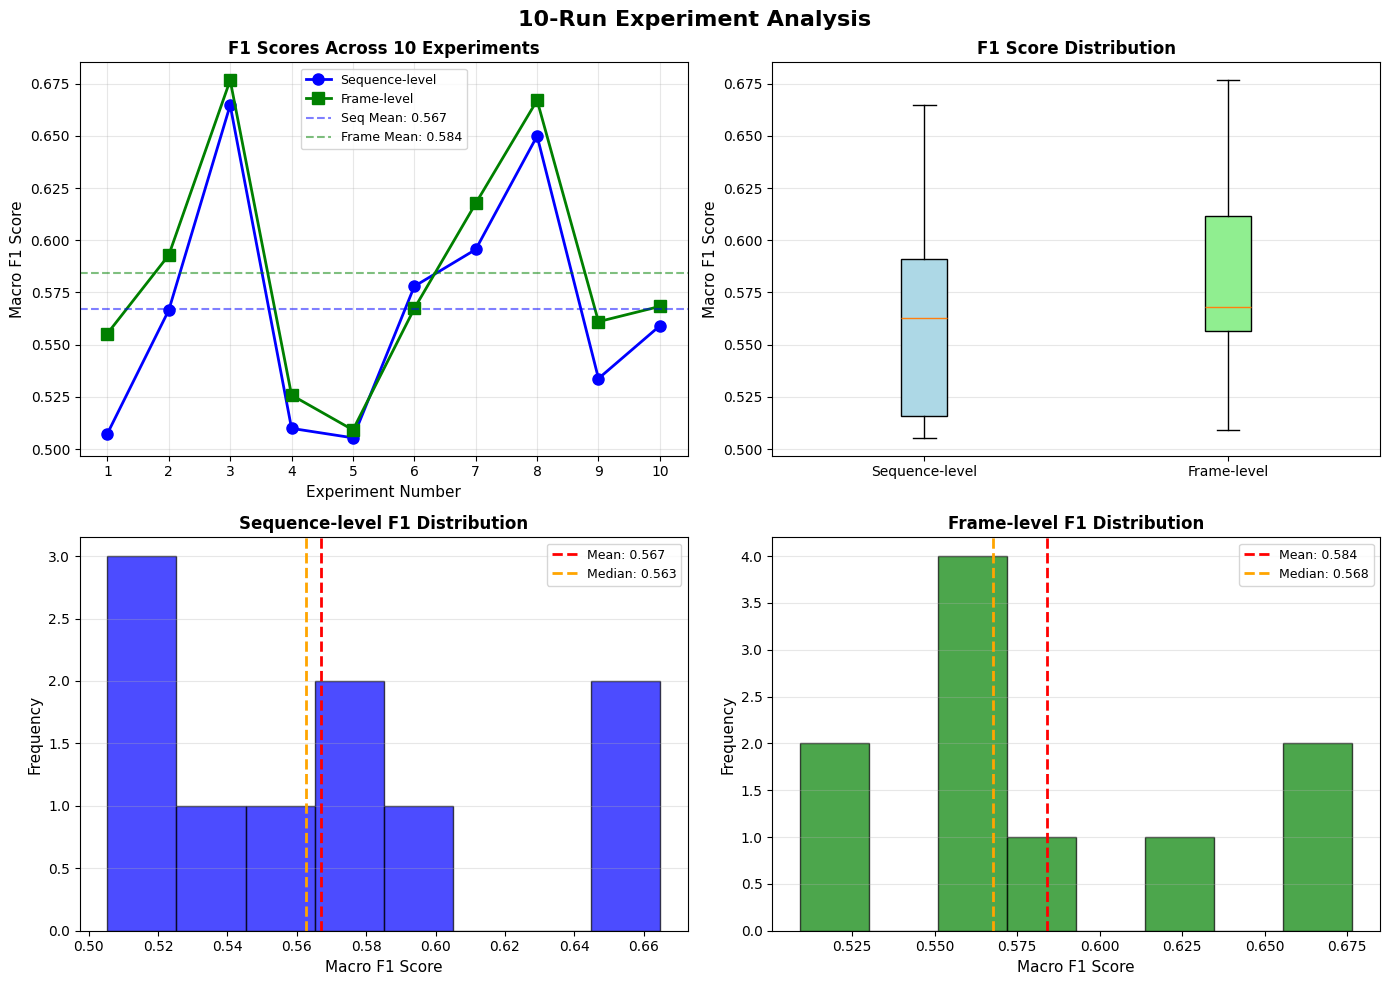


✓ Visualizations saved as '10_run_analysis.png'


In [8]:
# CELL 7: Visualizations

print("\n" + "="*70)
print("VISUALIZATIONS")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('10-Run Experiment Analysis', fontsize=16, fontweight='bold')

# Plot 1: F1 Scores by Experiment
ax1 = axes[0, 0]
x = np.arange(1, 11)
ax1.plot(x, sequence_f1_scores, marker='o', linewidth=2, markersize=8, label='Sequence-level', color='blue')
ax1.plot(x, frame_f1_scores, marker='s', linewidth=2, markersize=8, label='Frame-level', color='green')
ax1.axhline(seq_stats['mean'], color='blue', linestyle='--', alpha=0.5, label=f"Seq Mean: {seq_stats['mean']:.3f}")
ax1.axhline(frame_stats['mean'], color='green', linestyle='--', alpha=0.5, label=f"Frame Mean: {frame_stats['mean']:.3f}")
ax1.set_xlabel('Experiment Number', fontsize=11)
ax1.set_ylabel('Macro F1 Score', fontsize=11)
ax1.set_title('F1 Scores Across 10 Experiments', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(x)

# Plot 2: Distribution (Box Plot)
ax2 = axes[0, 1]
data_to_plot = [sequence_f1_scores, frame_f1_scores]
bp = ax2.boxplot(data_to_plot, labels=['Sequence-level', 'Frame-level'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightgreen')
ax2.set_ylabel('Macro F1 Score', fontsize=11)
ax2.set_title('F1 Score Distribution', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Histogram - Sequence-level
ax3 = axes[1, 0]
ax3.hist(sequence_f1_scores, bins=8, color='blue', alpha=0.7, edgecolor='black')
ax3.axvline(seq_stats['mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {seq_stats['mean']:.3f}")
ax3.axvline(seq_stats['median'], color='orange', linestyle='--', linewidth=2, label=f"Median: {seq_stats['median']:.3f}")
ax3.set_xlabel('Macro F1 Score', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Sequence-level F1 Distribution', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Histogram - Frame-level
ax4 = axes[1, 1]
ax4.hist(frame_f1_scores, bins=8, color='green', alpha=0.7, edgecolor='black')
ax4.axvline(frame_stats['mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {frame_stats['mean']:.3f}")
ax4.axvline(frame_stats['median'], color='orange', linestyle='--', linewidth=2, label=f"Median: {frame_stats['median']:.3f}")
ax4.set_xlabel('Macro F1 Score', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Frame-level F1 Distribution', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('10_run_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved as '10_run_analysis.png'")

In [9]:
# CELL 8: Best and Worst Experiments Analysis

print("\n" + "="*70)
print("BEST vs WORST EXPERIMENT ANALYSIS")
print("="*70)

# Find best and worst based on frame-level F1
best_idx = np.argmax(frame_f1_scores)
worst_idx = np.argmin(frame_f1_scores)

best_result = all_results[best_idx]
worst_result = all_results[worst_idx]

print(f"\n🏆 BEST EXPERIMENT (#{best_idx + 1}):")
print(f"   Seed: {best_result['seed']}")
print(f"   Sequence F1: {best_result['sequence_f1']:.4f}")
print(f"   Frame F1:    {best_result['frame_f1']:.4f}")
print(f"   Epochs:      {best_result['num_epochs']}")

print(f"\n💀 WORST EXPERIMENT (#{worst_idx + 1}):")
print(f"   Seed: {worst_result['seed']}")
print(f"   Sequence F1: {worst_result['sequence_f1']:.4f}")
print(f"   Frame F1:    {worst_result['frame_f1']:.4f}")
print(f"   Epochs:      {worst_result['num_epochs']}")

print(f"\n📈 PERFORMANCE GAP:")
print(f"   Sequence F1 Difference: {best_result['sequence_f1'] - worst_result['sequence_f1']:.4f}")
print(f"   Frame F1 Difference:    {best_result['frame_f1'] - worst_result['frame_f1']:.4f}")
print(f"   Relative Improvement:   {((best_result['frame_f1'] - worst_result['frame_f1']) / worst_result['frame_f1']) * 100:.1f}%")


BEST vs WORST EXPERIMENT ANALYSIS

🏆 BEST EXPERIMENT (#3):
   Seed: 456
   Sequence F1: 0.6647
   Frame F1:    0.6766
   Epochs:      43

💀 WORST EXPERIMENT (#5):
   Seed: 1024
   Sequence F1: 0.5054
   Frame F1:    0.5092
   Epochs:      31

📈 PERFORMANCE GAP:
   Sequence F1 Difference: 0.1592
   Frame F1 Difference:    0.1674
   Relative Improvement:   32.9%



CONFUSION MATRIX - BEST EXPERIMENT (#3)


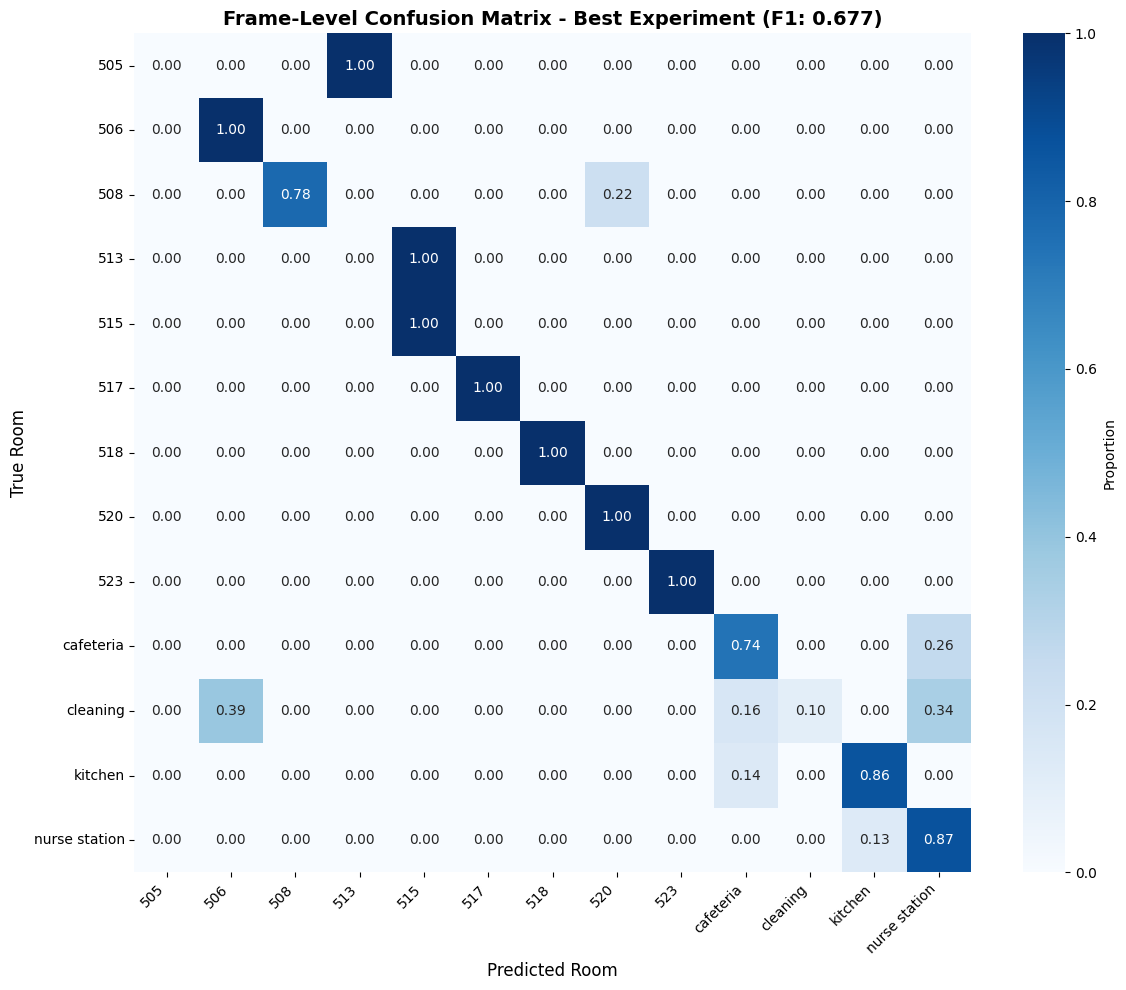


✓ Confusion matrix saved as 'best_experiment_confusion_matrix.png'


In [10]:
# CELL 9: Confusion Matrix for Best Experiment

print("\n" + "="*70)
print(f"CONFUSION MATRIX - BEST EXPERIMENT (#{best_idx + 1})")
print("="*70)

# Get predictions from best experiment
y_true_best = best_result['y_true_frames']
y_pred_best = best_result['y_pred_frames']
label_encoder_best = best_result['label_encoder']
classes = sorted(np.unique(y_true_best))

# Calculate confusion matrix
cm = confusion_matrix(y_true_best, y_pred_best, labels=classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Proportion'})
plt.title(f'Frame-Level Confusion Matrix - Best Experiment (F1: {best_result["frame_f1"]:.3f})',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Room', fontsize=12)
plt.ylabel('True Room', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_experiment_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved as 'best_experiment_confusion_matrix.png'")

In [11]:
# CELL 10: Save Results to CSV

print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save detailed results
results_df.to_csv('10_run_results.csv', index=False)
print("\n✓ Detailed results saved to: 10_run_results.csv")

# Save summary statistics
summary_df = pd.DataFrame([
    {
        'Metric': 'Sequence-level F1',
        'Mean': seq_stats['mean'],
        'Std': seq_stats['std'],
        'Min': seq_stats['min'],
        'Max': seq_stats['max'],
        'Median': seq_stats['median'],
        'Range': seq_stats['range']
    },
    {
        'Metric': 'Frame-level F1',
        'Mean': frame_stats['mean'],
        'Std': frame_stats['std'],
        'Min': frame_stats['min'],
        'Max': frame_stats['max'],
        'Median': frame_stats['median'],
        'Range': frame_stats['range']
    }
])

summary_df.to_csv('10_run_summary.csv', index=False)
print("✓ Summary statistics saved to: 10_run_summary.csv")


SAVING RESULTS

✓ Detailed results saved to: 10_run_results.csv
✓ Summary statistics saved to: 10_run_summary.csv


In [12]:
# CELL 11: Final Report

print("\n" + "="*70)
print("FINAL REPORT - 10-RUN EXPERIMENT")
print("="*70)

print(f"\n📋 EXPERIMENT CONFIGURATION:")
print(f"   Number of runs: 10")
print(f"   Seeds used: {seeds}")
print(f"   Model: LSTM (128→64→32 units)")
print(f"   Max sequence length: 50")
print(f"   Min sequence length: 3")

print(f"\n🎯 KEY FINDINGS:")
print(f"   Frame-level Macro F1: {frame_stats['mean']:.4f} ± {frame_stats['std']:.4f}")
print(f"   95% Confidence Interval: [{frame_stats['mean'] - 1.96*frame_stats['std']:.4f}, {frame_stats['mean'] + 1.96*frame_stats['std']:.4f}]")
print(f"   Best performance: {frame_stats['max']:.4f} (Seed: {best_result['seed']})")
print(f"   Worst performance: {frame_stats['min']:.4f} (Seed: {worst_result['seed']})")
print(f"   Performance range: {frame_stats['range']:.4f}")

print(f"\n💡 RECOMMENDATIONS:")
if frame_stats['std'] > 0.05:
    print("   ⚠️  High variance detected (std > 0.05)")
    print("   → Consider collecting more training data")
    print("   → Try simpler model architecture")
    print("   → Use ensemble methods (voting across multiple seeds)")
elif frame_stats['std'] > 0.03:
    print("   ⚡ Moderate variance detected (0.03 < std < 0.05)")
    print("   → Acceptable for research purposes")
    print("   → For production, consider running 5+ seeds and taking best/average")
else:
    print("   ✅ Low variance detected (std < 0.03)")
    print("   → Model is stable across random initializations")
    print("   → Single run results are reliable")

print(f"\n📊 WHEN REPORTING RESULTS:")
print(f"   Use: \"Frame-level Macro F1: {frame_stats['mean']:.3f} ± {frame_stats['std']:.3f} (n=10)\"")
print(f"   Or:  \"Frame-level Macro F1: {frame_stats['mean']:.3f} (min: {frame_stats['min']:.3f}, max: {frame_stats['max']:.3f})\"")

print("\n" + "="*70)
print("EXPERIMENT COMPLETE! 🎉")
print("="*70)


FINAL REPORT - 10-RUN EXPERIMENT

📋 EXPERIMENT CONFIGURATION:
   Number of runs: 10
   Seeds used: [42, 123, 456, 789, 1024, 2048, 3141, 5926, 7777, 9999]
   Model: LSTM (128→64→32 units)
   Max sequence length: 50
   Min sequence length: 3

🎯 KEY FINDINGS:
   Frame-level Macro F1: 0.5841 ± 0.0525
   95% Confidence Interval: [0.4813, 0.6869]
   Best performance: 0.6766 (Seed: 456)
   Worst performance: 0.5092 (Seed: 1024)
   Performance range: 0.1674

💡 RECOMMENDATIONS:
   ⚠️  High variance detected (std > 0.05)
   → Consider collecting more training data
   → Try simpler model architecture
   → Use ensemble methods (voting across multiple seeds)

📊 WHEN REPORTING RESULTS:
   Use: "Frame-level Macro F1: 0.584 ± 0.052 (n=10)"
   Or:  "Frame-level Macro F1: 0.584 (min: 0.509, max: 0.677)"

EXPERIMENT COMPLETE! 🎉
